In [158]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn import tree

In [167]:
work_folder="C:/Users/l/Downloads/Homework 2 data/"
file_name="D2.txt"
file=work_folder+file_name
file

'C:/Users/l/Downloads/Homework 2 data/D2.txt'

In [168]:
data=np.loadtxt(file)
data

array([[0.315561, 0.956006, 1.      ],
       [0.344972, 0.693422, 1.      ],
       [0.398419, 0.974354, 1.      ],
       ...,
       [0.384576, 0.609262, 0.      ],
       [0.843186, 0.848278, 1.      ],
       [0.691812, 0.751075, 1.      ]])

In [90]:
def labels(data):
    return data[:,2]
labels(data)

array([1., 1., 1., ..., 1., 1., 1.])

In [91]:
def entropy(data):
    unique,counts=np.unique(labels(data),return_counts=True)
    if len(unique)==1:
        return 0
    else:
        p=counts/counts.sum()
        return -p[0]*math.log2(p[0])-p[1]*math.log2(p[1])

entropy(data)

0.9715325521731815

In [92]:
def split_data(data,split):
    feature=split[0]
    threshold=split[1]
    return data[data[:,feature]>=threshold,:],data[data[:,feature]<threshold,:]
split_data(data,(0,0.1))

(array([[0.10047 , 0.852253, 0.      ],
        [0.100783, 0.348572, 0.      ],
        [0.100853, 0.603693, 0.      ],
        ...,
        [1.499284, 0.447541, 1.      ],
        [1.499313, 1.092598, 1.      ],
        [1.499767, 0.661564, 1.      ]]),
 array([[-1.499372,  0.976384,  1.      ],
        [-1.499224, -0.517983,  1.      ],
        [-1.49888 , -1.271624,  1.      ],
        ...,
        [ 0.099194,  1.150909,  1.      ],
        [ 0.09925 ,  1.165741,  1.      ],
        [ 0.09981 , -0.119271,  0.      ]]))

In [93]:
def gain_rate(data,split):
    #compute original entropy
    entropy_before_split=entropy(data)
    
    # do split
    d0,d1=split_data(data,split)
    
    #compute entropy of the split
    num_father=data.shape[0]
    num_d0=d0.shape[0]
    num_d1=d1.shape[0]
    p0=num_d0/num_father
    p1=num_d1/num_father
    if p0*p1==0:
        #if the split has no info, return zero information gain
        return 0
    else:
        entropy_of_split=-p0*math.log2(p0)-p1*math.log2(p1)

        #compute entropy after splitting
        entropy_after_split=p0*entropy(d0)+p1*entropy(d1)

        gain_rate=(entropy_before_split-entropy_after_split)/entropy_of_split
       # return gain_rate,entropy_before_split,entropy_of_split,entropy_after_split
        return gain_rate


In [94]:
def determine_candidates(data):
    result=pd.DataFrame(columns=['Feature','Threshold','InfoGainRate'])
    for feature in [0,1]:
        unique_feature,counts=np.unique(data[:,feature],return_counts=True)
        if len(unique_feature)==0:
            continue
        else:
            for threshold in unique_feature:
                split=(feature,threshold)
                result.loc[len(result)]=np.array([int(feature),threshold,gain_rate(data,split)])
    return result


In [95]:
def make_subtree(data,current_chain):
    #branches are (split(feature,threshold),side)
    #((0,1),'l')) means the criterion is x0>=1
    #branches make a chain in a list, ending at a leaf
    #a leaf is a singleton list with the final label
    result=determine_candidates(data)
    if (result.shape[0]==0) or (max(result.InfoGainRate)==0):
        #stop splitting, determine the final label
        unique_label,counts=np.unique(data[:,2],return_counts=True)
        if len(unique_label)==1:
            final_label=unique_label[0]
        else:
            if counts[0]>counts[1]:
                final_label=0
            else:
                final_label=1
        #return final criterion: make an leaf
        return [current_chain+[int(final_label)]]
    else:
        #keep splitting, pass down the updated criterion
        best_loc=np.where(result.InfoGainRate==result.InfoGainRate.max())[0][0]
        best_feature=result.Feature[best_loc]
        best_threshold=result.Threshold[best_loc]
        split=(int(best_feature),best_threshold)
        data_left,data_right=split_data(data,split)
        chain_left=current_chain+[(split,"l")]
        chain_right=current_chain+[(split,"r")]
        subtree_left=make_subtree(data_left,chain_left)
        subtree_right=make_subtree(data_right,chain_right)
        return subtree_left+subtree_right




In [96]:
def translate_tree(tree):
    result=[]
    for chain in tree:
        now_result=''
        for node in chain:
            if type(node)==int:
                #for leaf, add the label
                now_result=now_result+','+'y='+str(node)
            else:
                #for branch, add the criterion
                feature=node[0][0]
                threshold=node[0][1]
                sign=">=" if node[1]=="l" else "<"
                criterion="x"+str(feature)+sign+str(threshold)
                now_result=now_result+','+criterion
        result=result+[now_result[1:]]
    return result
# translate_tree(make_subtree(data,[]))

In [97]:
def predict_tree(x,tree):
    for chain in tree:
        for node in chain:
            if type(node)==int:
                #for leaf, add the label
                return node
            else:
                #for branch, add the criterion
                feature=node[0][0]
                threshold=node[0][1]
                if node[1]=="l":
                    if not x[feature]>=threshold:
                        break
                else:
                    if not x[feature]<threshold:
                        break

In [98]:
# d0=data[data[:,2]==0]
# d1=data[data[:,2]==1]
# plt.figure()
# plt.scatter(d0[:,0],d0[:,1])
# plt.scatter(d1[:,0],d1[:,1])
# plt.plot([0,1],[0.201829,0.201829],color="red")


In [99]:
perm=np.random.permutation(data.shape[0])


In [100]:
data=data[perm,:]
d32_train=data[:32,]
d32_test=data[32:,]
d128_train=data[:128,]
d128_test=data[128:,]
d512_train=data[:512,]
d512_test=data[512:,]
d2048_train=data[:2048,]
d2048_test=data[2048:,]
d8192_train=data[:8192,]
d8192_test=data[8192:,]



In [101]:
result=pd.DataFrame(columns=['model','nodes','ErrorRate'])
tree32=make_subtree(d32_train,[])
predict_y=[]
for x in d32_test:
    predict_y=predict_y+[predict_tree(x,tree32)]
test_y=d32_test[:,2]

result.loc[len(result)]=[32,len(tree32),np.count_nonzero(predict_y-test_y)/len(test_y)]
result

,model,nodes,ErrorRate
0,32.0,4.0,0.195225


In [102]:
tree128=make_subtree(d128_train,[])
predict_y=[]
for x in d128_test:
    predict_y=predict_y+[predict_tree(x,tree128)]
test_y=d128_test[:,2]

result.loc[len(result)]=[128,len(tree128),np.count_nonzero(predict_y-test_y)/len(test_y)]
result

,model,nodes,ErrorRate
0,32.0,4.0,0.195225
1,128.0,13.0,0.081949


In [103]:
tree512=make_subtree(d512_train,[])
predict_y=[]
for x in d512_test:
    predict_y=predict_y+[predict_tree(x,tree512)]
test_y=d512_test[:,2]

result.loc[len(result)]=[512,len(tree512),np.count_nonzero(predict_y-test_y)/len(test_y)]
result

,model,nodes,ErrorRate
0,32.0,4.0,0.195225
1,128.0,13.0,0.081949
2,512.0,13.0,0.062289


In [104]:
tree2048=make_subtree(d2048_train,[])
predict_y=[]
for x in d2048_test:
    predict_y=predict_y+[predict_tree(x,tree2048)]
test_y=d2048_test[:,2]

result.loc[len(result)]=[2048,len(tree2048),np.count_nonzero(predict_y-test_y)/len(test_y)]
result

,model,nodes,ErrorRate
0,32.0,4.0,0.195225
1,128.0,13.0,0.081949
2,512.0,13.0,0.062289
3,2048.0,13.0,0.038984


In [105]:
tree8192=make_subtree(d8192_train,[])
predict_y=[]
for x in d8192_test:
    predict_y=predict_y+[predict_tree(x,tree8192)]
test_y=d8192_test[:,2]

result.loc[len(result)]=[8192,len(tree8192),np.count_nonzero(predict_y-test_y)/len(test_y)]
result

,model,nodes,ErrorRate
0,32.0,4.0,0.195225
1,128.0,13.0,0.081949
2,512.0,13.0,0.062289
3,2048.0,13.0,0.038984
4,8192.0,13.0,0.020465


array([[-1.5  , -1.5  ],
       [-1.499, -1.5  ],
       [-1.498, -1.5  ],
       ...,
       [ 1.597,  1.59 ],
       [ 1.598,  1.59 ],
       [ 1.599,  1.59 ]])

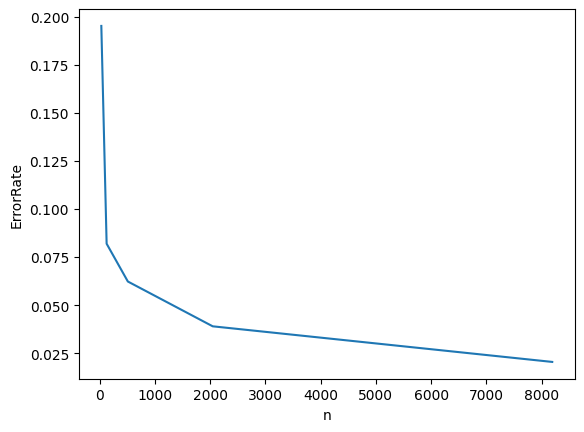

In [120]:
plt.plot(q7.model,q7.ErrorRate,)
plt.xlabel("n")
plt.ylabel("ErrorRate")

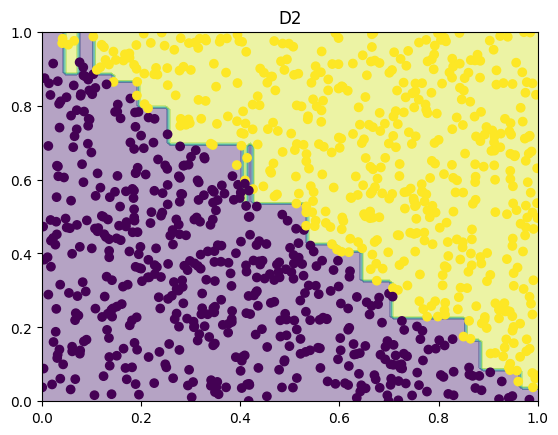

In [169]:
tree=make_subtree(data,[])
# clf =tree.DecisionTreeClassifier()
# clf=clf.fit(x_train,y_train)

xx,yy=np.meshgrid(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01))
z=[]
for point in np.c_[xx.ravel(),yy.ravel()]:
    z=z+[predict_tree(point,tree)]
z=np.array(z).reshape(xx.shape)

plt.contourf(xx,yy,z,alpha=0.4)
plt.scatter(data[:,0],data[:,1],c=data[:,2],alpha=1)
plt.title('D'+str(2))
plt.show()  


In [154]:
#question 3
names=globals()
result=pd.DataFrame(columns=['model','nodes','ErrorRate'])
for i in [32,128,512,2048,8192]:
    x_train=names.get('d'+str(i)+'_train')[:,:2]
    y_train=names.get('d'+str(i)+'_train')[:,2]
    x_test=names.get('d'+str(i)+'_test')[:,:2]
    y_test=names.get('d'+str(i)+'_test')[:,2]

    clf =tree.DecisionTreeClassifier()
    clf=clf.fit(x_train,y_train)

    z=clf.predict(x_test)
    result.loc[len(result)]=[int(i),int(clf.tree_.node_count),np.count_nonzero(z-y_test)/len(y_test)]
print(result.to_latex())

\begin{tabular}{lrrr}
\toprule
 & model & nodes & ErrorRate \\
\midrule
0 & 32.000000 & 7.000000 & 0.166433 \\
1 & 128.000000 & 29.000000 & 0.121049 \\
2 & 512.000000 & 47.000000 & 0.054911 \\
3 & 2048.000000 & 127.000000 & 0.034457 \\
4 & 8192.000000 & 229.000000 & 0.018252 \\
\bottomrule
\end{tabular}



Text(0, 0.5, 'ErrorRate')

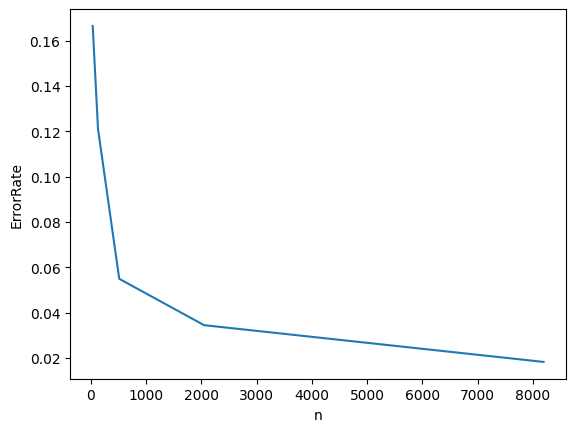

In [157]:
plt.plot(result.model,result.ErrorRate,)
plt.xlabel("n")
plt.ylabel("ErrorRate")

In [ ]:
# question 4
a=0
b=4*math.pi
x_train=np.sort(np.random.uniform(a,b,100))
y_train=np.sin(x_train)
x_test=np.sort(np.random.uniform(a,b,100))
y_test=np.sin(x_test)

plt.scatter(x_train,y_train)

poly = interpolate.lagrange(x_train,y_train)
Polynomial(poly.coef[::-1]).coef

plt.scatter(x_train, y_train, label='data')
plt.plot(x_train, Polynomial(poly.coef[::-1])(x_train), label='Polynomial')
plt.legend()
# plt.show()
train_error=np.sqrt(sum(np.square(Polynomial(poly.coef[::-1])(x_train)-y_train))/len(y_train))
print(train_error)
test_error=np.sqrt(sum(np.square(Polynomial(poly.coef[::-1])(x_test)-y_test))/len(y_test))
print(test_error)

df=pd.DataFrame(columns=["StandardError","TrainingError","TestError"])
for SD in [1,5,10,20,30,40,50,60,70,80,90,100,150,200,500]:
    e=np.random.normal(0,SD,100)
    x_train_new=np.sort(x_train+e)
    y_train_new=np.sin(x_train_new)

    # plt.scatter(x_train_new,y_train_new)

    poly = interpolate.lagrange(x_train_new,y_train_new)
    Polynomial(poly.coef[::-1]).coef

    # plt.scatter(x_train_new, y_train_new, label='data')
    # plt.plot(x_train_new, Polynomial(poly.coef[::-1])(x_train_new), label='Polynomial')
    # plt.legend()
    # plt.show()

    # plt.scatter(x_test, y_test, label='data')
    # plt.plot(x_test, Polynomial(poly.coef[::-1])(x_test), label='Polynomial')
    # plt.legend()

    train_error=np.log(np.sqrt(sum(np.square(Polynomial(poly.coef[::-1])(x_train_new)-y_train_new))/len(y_train_new)))
    train_error
    test_error=np.log(np.sqrt(sum(np.square(Polynomial(poly.coef[::-1])(x_test)-y_test))/len(y_test)))
    test_error
    df.loc[len(df)]=[SD,train_error,test_error]
df

plt.plot(df.StandardError,df.iloc[:,[1,2]])
print(df.to_latex())